In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import KFold, cross_validate, GridSearchCV

from sklearn.model_selection import KFold as SKKFold


In [47]:
# Load data
df = pd.read_csv('data/ratings_small.csv')

In [48]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[["userId","movieId","rating"]], reader)

n_users = df["userId"].nunique()
n_items = df["movieId"].nunique()
n_ratings = len(df)
print(f"users={n_users}, items={n_items}, ratings={n_ratings}")


users=671, items=9066, ratings=100004


In [49]:
def cv_score_surprise(algo, data, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    rmses, maes = [], []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        preds = algo.test(testset)
        rmses.append(accuracy.rmse(preds, verbose=False))
        maes.append(accuracy.mae(preds, verbose=False))
    return {"rmse": float(np.mean(rmses)), "mae": float(np.mean(maes))}

In [50]:
# Build PMF data
uid_map = {u:i for i,u in enumerate(df["userId"].unique())}
iid_map = {i:j for j,i in enumerate(df["movieId"].unique())}

X_ui = np.asarray([(uid_map[u], iid_map[i], r)
                   for u,i,r in df[["userId","movieId","rating"]].itertuples(index=False, name=None)],
                  dtype=float)
X_ui = X_ui.astype(np.float64)  

n_users = len(uid_map)
n_items = len(iid_map)

def pmf_train(triples, n_users, n_items, k=30, lr=0.01, reg=0.05, n_epochs=20, seed=42):
    rng = np.random.default_rng(seed)
    P = 0.1 * rng.standard_normal((n_users, k))
    Q = 0.1 * rng.standard_normal((n_items, k))
    for _ in range(n_epochs):
        rng.shuffle(triples)
        for u, i, r in triples:
            u = int(u); i = int(i); r = float(r)
            pred = P[u] @ Q[i]
            err = r - pred
            # SGD updates with L2 regularization
            Pu = P[u] + lr * (err * Q[i] - reg * P[u])
            Qi = Q[i] + lr * (err * P[u] - reg * Q[i])
            P[u], Q[i] = Pu, Qi
    return P, Q

def pmf_predict(P, Q, pairs, lo=0.5, hi=5.0):
    y = np.fromiter((P[int(u)] @ Q[int(i)] for u,i in pairs), dtype=float, count=len(pairs))
    return np.clip(y, lo, hi)

def rmse_mae(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    mae  = float(np.mean(np.abs(y_true - y_pred)))
    return rmse, mae


In [51]:
# 5-fold CV for PMF 

def cv_score_pmf(X, n_users, n_items, n_splits=5, seed=42,
                 k=30, lr=0.01, reg=0.05, n_epochs=20):
    kf = SKKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    rmses, maes = [], []
    for tr_idx, te_idx in kf.split(X):
        train = X[tr_idx]
        test  = X[te_idx]
        P, Q = pmf_train(train, n_users, n_items, k=k, lr=lr, reg=reg, n_epochs=n_epochs, seed=seed)
        y_hat = pmf_predict(P, Q, test[:, :2])
        rm, ma = rmse_mae(test[:, 2], y_hat)
        rmses.append(rm); maes.append(ma)
    return {"rmse": float(np.mean(rmses)), "mae": float(np.mean(maes))}

pmf_scores = cv_score_pmf(X_ui, n_users, n_items)  
pmf_scores


{'rmse': 1.0759046646865964, 'mae': 0.7927106027462012}

In [52]:
# Baseline KNN at K=20 for both user & item
user_knn_20 = KNNBasic(k=20, sim_options={"name":"cosine", "user_based":True})
item_knn_20 = KNNBasic(k=20, sim_options={"name":"cosine", "user_based":False})

user_knn_scores = cv_score_surprise(user_knn_20, data)
item_knn_scores = cv_score_surprise(item_knn_20, data)

summary_c = pd.DataFrame({
    "PMF": pmf_scores,
    "UserKNN@20": user_knn_scores,
    "ItemKNN@20": item_knn_scores
}).T

summary_c

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


,rmse,mae
PMF,1.075905,0.792711
UserKNN@20,0.996640,0.768190
ItemKNN@20,1.017126,0.794075


In [53]:
# Which is best by RMSE / MAE?
print("Sorted by RMSE:")
display(summary_c.sort_values("rmse"))

print("Sorted by MAE:")
display(summary_c.sort_values("mae"))

best_rmse_model = summary_c["rmse"].idxmin()
best_mae_model  = summary_c["mae"].idxmin()
print("Best by RMSE:", best_rmse_model)
print("Best by MAE: ", best_mae_model)


Sorted by RMSE:


,rmse,mae
UserKNN@20,0.996640,0.768190
ItemKNN@20,1.017126,0.794075
PMF,1.075905,0.792711


Sorted by MAE:


,rmse,mae
UserKNN@20,0.996640,0.768190
PMF,1.075905,0.792711
ItemKNN@20,1.017126,0.794075


Best by RMSE: UserKNN@20
Best by MAE:  UserKNN@20


In [54]:
# similarity sweep
def sweep_similarity(user_based: bool, sims=("cosine","msd","pearson"), k=20):
    rows = []
    for s in sims:
        algo = KNNBasic(k=k, sim_options={"name": s, "user_based": user_based})
        m = cv_score_surprise(algo, data)
        rows.append({"similarity": s, **m})
    return pd.DataFrame(rows)

user_sim_df = sweep_similarity(True)
item_sim_df = sweep_similarity(False)

print("UserKNN similarities:\n", user_sim_df)
print("ItemKNN similarities:\n", item_sim_df)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

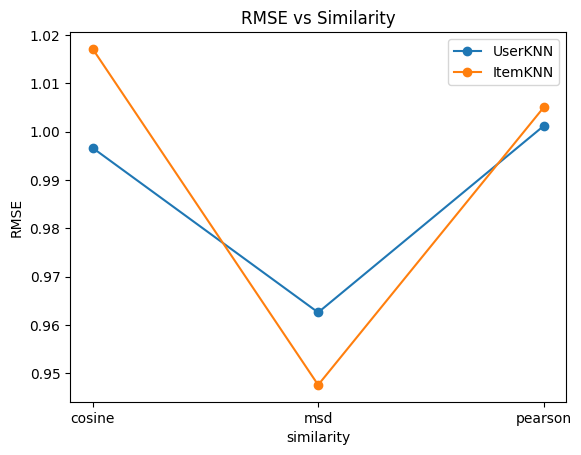

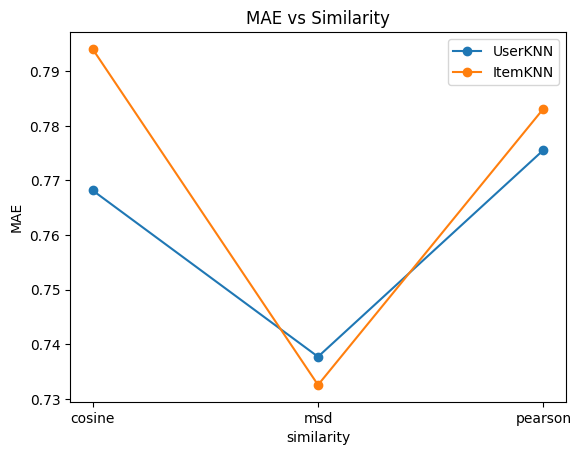

In [55]:
# plots for part e
for metric, title in [("rmse","RMSE vs Similarity"), ("mae","MAE vs Similarity")]:
    plt.figure()
    plt.plot(user_sim_df["similarity"], user_sim_df[metric], marker="o", label="UserKNN")
    plt.plot(item_sim_df["similarity"], item_sim_df[metric], marker="o", label="ItemKNN")
    plt.title(title); plt.xlabel("similarity"); plt.ylabel(metric.upper()); plt.legend(); plt.show()


In [56]:
# K sweep
K_vals = [5, 10, 20, 40, 80]

def sweep_k(user_based: bool, sim="cosine", K=K_vals):
    rows=[]
    for k in K:
        algo = KNNBasic(k=k, sim_options={"name": sim, "user_based": user_based})
        m = cv_score_surprise(algo, data)
        rows.append({"k": int(k), **m})
    return pd.DataFrame(rows)

user_k_df = sweep_k(True, sim="cosine")
item_k_df = sweep_k(False, sim="cosine")

print("UserKNN K curve:\n", user_k_df)
print("ItemKNN K curve:\n", item_k_df)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

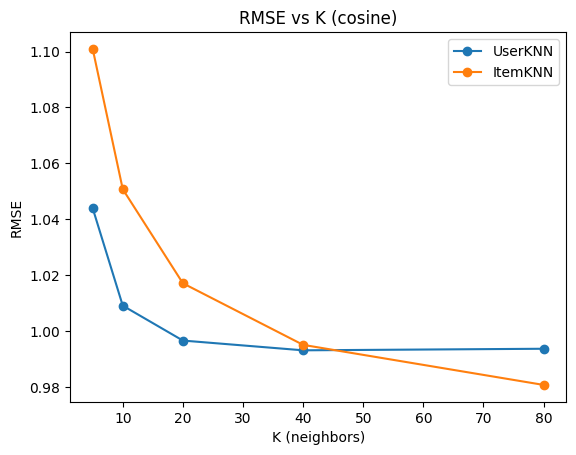

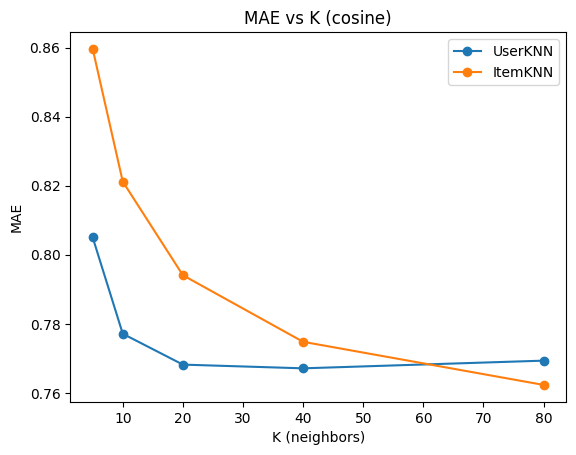

In [57]:
# plots for part f
for metric, title in [("rmse","RMSE vs K (cosine)"), ("mae","MAE vs K (cosine)")]:
    plt.figure()
    plt.plot(user_k_df["k"], user_k_df[metric], marker="o", label="UserKNN")
    plt.plot(item_k_df["k"], item_k_df[metric], marker="o", label="ItemKNN")
    plt.title(title); plt.xlabel("K (neighbors)"); plt.ylabel(metric.upper()); plt.legend(); plt.show()


In [58]:
# best K by RMSE
best_user_k = int(user_k_df.loc[user_k_df["rmse"].idxmin(), "k"])
best_item_k = int(item_k_df.loc[item_k_df["rmse"].idxmin(), "k"])
best_user_rmse = float(user_k_df["rmse"].min())
best_item_rmse = float(item_k_df["rmse"].min())

print(f"Best K (UserKNN): {best_user_k}  with RMSE={best_user_rmse:.4f}")
print(f"Best K (ItemKNN): {best_item_k}  with RMSE={best_item_rmse:.4f}")
print("Same K? ", best_user_k == best_item_k)


Best K (UserKNN): 40  with RMSE=0.9931
Best K (ItemKNN): 80  with RMSE=0.9808
Same K?  False
